<a href="https://colab.research.google.com/github/nicoMP/MVP_Predict/blob/main/CS_4442.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project : NBA MVP Predictor
Modifying an existing neural network to predict MVP's given features collected

*from:*
* *https://www.basketball-reference.com/awards/mvp.html*


*Using and Modifiying Kaggle's user: @robertsunderhaft work found at https://www.kaggle.com/datasets/robertsunderhaft/nba-player-season-statistics-with-mvp-win-share

*Using and Modifiying Kaggle's user: @vivovinco work found at https://www.kaggle.com/datasets/vivovinco/20222023-nba-player-stats-regular

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import missingno as msno

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import model_selection, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
# Other packages
from scipy.stats import norm
from scipy import stats
seed = 0
data = pd.read_csv("NBA_Dataset.csv").dropna()

## Part 1: Data Selection and Preperation

### 2. Trimming Data


In [ ]:


#prunning data
cols_to_drop = ['gs', 'pos', 'mp', 'team_id', 'fg_per_g', 'fga_per_g', 'fg3_per_g', 'fg3a_per_g', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct',
                'ft_per_g', 'fta_per_g', 'orb_per_g', 'drb_per_g', 'pf_per_g', 'tov_per_g', 'fg3a_per_fga_pct',
                'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct',
                'usg_pct', 'ows', 'dws', 'ws_per_48', 'obpm', 'dbpm', 'mov', 'mov_adj']
df = data.drop(cols_to_drop, axis=1)

# df = df.drop(df[(df['award_share'] == 0) | (df['pts_per_g'] < 13.8) | (df['trb_per_g'] < 3.3) |
#                 (df['ast_per_g'] < 1.3) | (df['mp_per_g'] < 30) | (df['g'] < 49)].index)
df = df.drop(df[(df['award_share'] == 0)].index)

correlation_df = df.drop(['season'], axis=1).corr()
pd.DataFrame(correlation_df.corr())



,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,award_share,win_loss_pct
age,1.000000,-0.390108,-0.673723,-0.000391,0.054577,0.076231,0.200617,-0.165399,-0.063600,-0.438361,-0.123273,-0.442712,-0.301637,0.083163,-0.458231,-0.299457,-0.485001,-0.309752,0.264206
g,-0.390108,1.000000,0.348233,0.044753,-0.131407,-0.030869,-0.005793,-0.011218,-0.013517,0.179938,-0.016383,0.088077,-0.047457,-0.018276,0.463808,-0.022287,0.297447,0.115580,-0.034972
mp_per_g,-0.673723,0.348233,1.000000,-0.354847,0.022154,-0.494053,-0.145487,0.097403,0.074133,0.500758,0.027952,0.573927,0.186560,-0.474690,0.328741,0.190350,0.438558,0.257560,-0.525531
fg_pct,-0.000391,0.044753,-0.354847,1.000000,-0.680814,0.885061,-0.574917,0.685710,-0.604666,-0.609954,0.668752,-0.020527,0.347188,0.729464,0.338385,0.082934,0.016634,0.207009,0.310866
fg3_pct,0.054577,-0.131407,0.022154,-0.680814,1.000000,-0.297883,0.815855,-0.816068,0.683968,0.416700,-0.837068,0.093765,-0.091966,-0.078743,-0.135677,0.162227,0.114395,-0.119466,-0.144934
efg_pct,0.076231,-0.030869,-0.494053,0.885061,-0.297883,1.000000,-0.193827,0.353683,-0.308943,-0.509150,0.330999,0.034951,0.438957,0.949725,0.398479,0.275403,0.142273,0.248084,0.386689
ft_pct,0.200617,-0.005793,-0.145487,-0.574917,0.815855,-0.193827,1.000000,-0.848377,0.613457,0.289602,-0.827390,0.097931,-0.072951,0.095776,-0.058608,0.141343,0.097245,-0.088467,-0.025119
trb_per_g,-0.165399,-0.011218,0.097403,0.685710,-0.816068,0.353683,-0.848377,1.000000,-0.825897,-0.529654,0.948370,0.156302,0.340036,0.154043,0.267262,0.015362,0.029593,0.271497,0.033607
ast_per_g,-0.063600,-0.013517,0.074133,-0.604666,0.683968,-0.308943,0.613457,-0.825897,1.000000,0.760885,-0.825150,-0.096656,-0.076559,-0.158525,-0.013884,0.323707,0.303645,0.017039,-0.010961
stl_per_g,-0.438361,0.179938,0.500758,-0.609954,0.416700,-0.509150,0.289602,-0.529654,0.760885,1.000000,-0.506887,0.145508,0.051092,-0.420739,0.173297,0.394458,0.496163,0.139601,-0.235612


### 1. Analyzing Data

In [ ]:
season_means =pd.DataFrame(data.groupby("season").mean()).reset_index()
season_means['group'] = (season_means.index // 5) + 1
season_means = season_means.groupby("group").mean().reset_index()
season_means.drop("group",1)
season_means["season"] = season_means["season"] +1
season_means
disimilarityMatrix = metrics.pairwise.cosine_similarity(season_means.drop("season",axis = 1))
disimilarityMatrix.shape
season_labels = season_means["season"].values

<ipython-input-35-a2ab5416303f>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  season_means.drop("group",1)


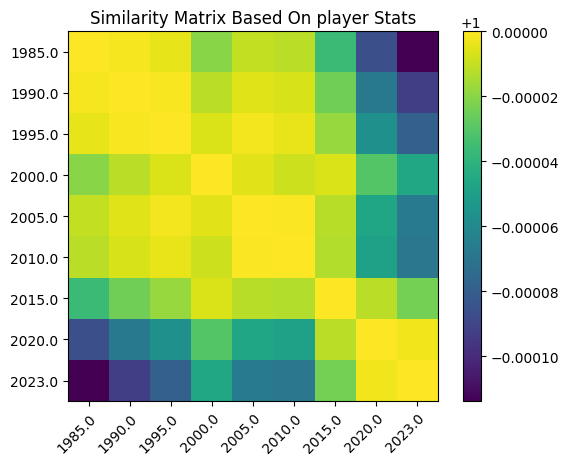

,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,award_share,win_loss_pct
age,1.000000,-0.390108,-0.673723,-0.000391,0.054577,0.076231,0.200617,-0.165399,-0.063600,-0.438361,-0.123273,-0.442712,-0.301637,0.083163,-0.458231,-0.299457,-0.485001,-0.309752,0.264206
g,-0.390108,1.000000,0.348233,0.044753,-0.131407,-0.030869,-0.005793,-0.011218,-0.013517,0.179938,-0.016383,0.088077,-0.047457,-0.018276,0.463808,-0.022287,0.297447,0.115580,-0.034972
mp_per_g,-0.673723,0.348233,1.000000,-0.354847,0.022154,-0.494053,-0.145487,0.097403,0.074133,0.500758,0.027952,0.573927,0.186560,-0.474690,0.328741,0.190350,0.438558,0.257560,-0.525531
fg_pct,-0.000391,0.044753,-0.354847,1.000000,-0.680814,0.885061,-0.574917,0.685710,-0.604666,-0.609954,0.668752,-0.020527,0.347188,0.729464,0.338385,0.082934,0.016634,0.207009,0.310866
fg3_pct,0.054577,-0.131407,0.022154,-0.680814,1.000000,-0.297883,0.815855,-0.816068,0.683968,0.416700,-0.837068,0.093765,-0.091966,-0.078743,-0.135677,0.162227,0.114395,-0.119466,-0.144934
efg_pct,0.076231,-0.030869,-0.494053,0.885061,-0.297883,1.000000,-0.193827,0.353683,-0.308943,-0.509150,0.330999,0.034951,0.438957,0.949725,0.398479,0.275403,0.142273,0.248084,0.386689
ft_pct,0.200617,-0.005793,-0.145487,-0.574917,0.815855,-0.193827,1.000000,-0.848377,0.613457,0.289602,-0.827390,0.097931,-0.072951,0.095776,-0.058608,0.141343,0.097245,-0.088467,-0.025119
trb_per_g,-0.165399,-0.011218,0.097403,0.685710,-0.816068,0.353683,-0.848377,1.000000,-0.825897,-0.529654,0.948370,0.156302,0.340036,0.154043,0.267262,0.015362,0.029593,0.271497,0.033607
ast_per_g,-0.063600,-0.013517,0.074133,-0.604666,0.683968,-0.308943,0.613457,-0.825897,1.000000,0.760885,-0.825150,-0.096656,-0.076559,-0.158525,-0.013884,0.323707,0.303645,0.017039,-0.010961
stl_per_g,-0.438361,0.179938,0.500758,-0.609954,0.416700,-0.509150,0.289602,-0.529654,0.760885,1.000000,-0.506887,0.145508,0.051092,-0.420739,0.173297,0.394458,0.496163,0.139601,-0.235612


In [ ]:

fig, ax = plt.subplots()


im = ax.imshow(disimilarityMatrix)


ax.set_xticks(np.arange(len(season_labels)))
ax.set_yticks(np.arange(len(season_labels)))
ax.set_xticklabels(season_labels)
ax.set_yticklabels(season_labels)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


cbar = ax.figure.colorbar(im, ax=ax)


ax.set_title("Similarity Matrix Based On player Stats")
plt.show()
pd.DataFrame(correlation_df.corr())


### Test Train Split

In [ ]:
y = df["award_share"]
X = df.drop(["award_share","player", "season"],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state= seed)

## Part 2: Training Models


### a) Random Forrest

####Cross Validation and Selecting best Model Params

In [ ]:
rfr = RandomForestRegressor()
gsc = GridSearchCV(
        estimator=rfr,
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 500, 1000),
            'max_features' : [1, 2, 10, 30, 100],
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
gsc_result = gsc.fit(X_train, y_train)
RFR= gsc_result.best_estimator_

#### Visualizing Predictions

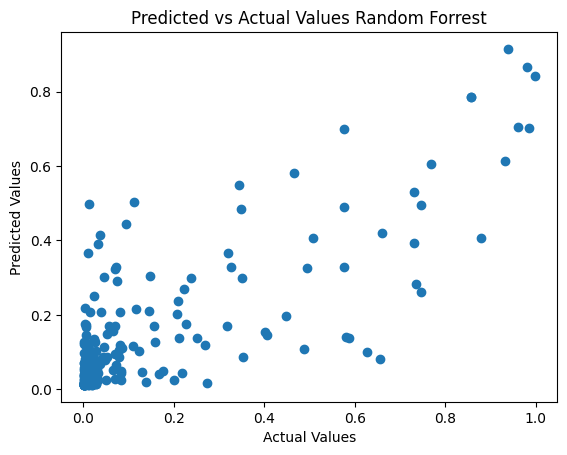

R2 Score =  0.6101886078896657
RMSE =  0.025618591810926947


In [ ]:

y_pred = RFR.predict(X_test)
r2_score = metrics.r2_score(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values Random Forrest')
plt.show()
print("R2 Score = ", r2_score)
print("RMSE = ", rmse)

### b) ADA Model

####Cross Validation and Selecting best Model Params

In [ ]:
ada = AdaBoostRegressor()


grid_search = GridSearchCV(ada, param_grid={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'loss': ['linear', 'square']},
     scoring='neg_mean_squared_error', cv=5, n_jobs=-1)


grid_search.fit(X_train, y_train)


ADA = grid_search.best_estimator_



#### Visualizing Predictions

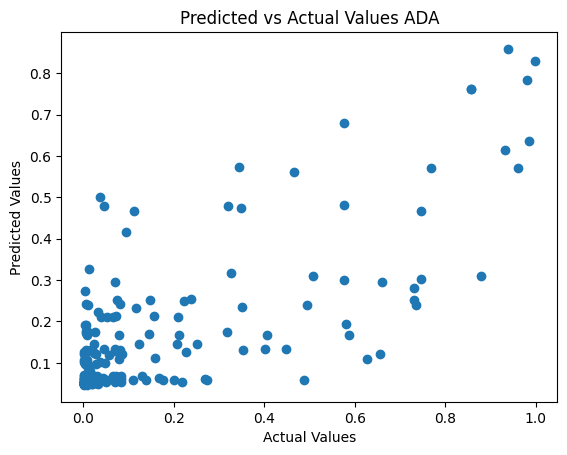

R2 Score =  0.5545062383472339
RMSE =  0.029278063866502443


In [ ]:

y_pred = ADA.predict(X_test)
r2_score = metrics.r2_score(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values ADA')
plt.show()
print("R2 Score = ", r2_score)
print("RMSE = ", rmse)

### c) SVM

####Cross Validation and Selecting best Model Params

In [ ]:
svm = SVR()


grid_search = GridSearchCV(svm, param_grid= {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10]},
    scoring='neg_mean_squared_error', cv=5, n_jobs=-1)


grid_search.fit(X_train, y_train)


SVM = grid_search.best_estimator_


#### Visualizing Predictions

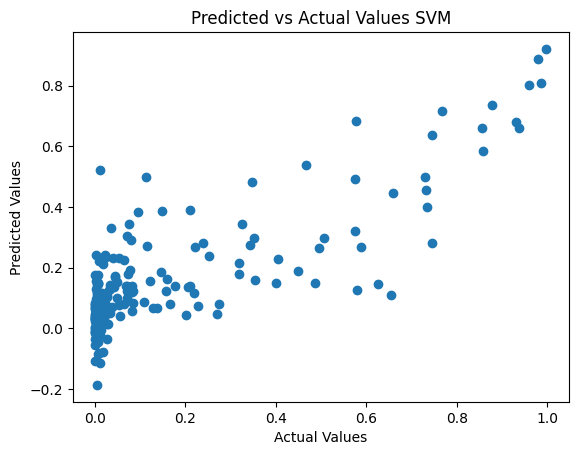

R2 Score =  0.6604130511412041
RMSE =  0.02231781729116115


In [ ]:

y_pred = SVM.predict(X_test)
r2_score = metrics.r2_score(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values SVM')
plt.show()
print("R2 Score = ", r2_score)
print("RMSE = ", rmse)

In [ ]:
df_pred = data.drop(cols_to_drop, axis=1)

# Predicting MVP for past seasons

In [ ]:
def predict_mvp(model, data, year):
  df = data[data['season'] == year]
  df_features = df.drop(["award_share","player", "season"],axis = 1)
  pred = model.predict(df_features)

  df['predicted_award_share'] = pred
  df = df.sort_values(by='predicted_award_share', ascending=False)

  return df.head(5)

In [ ]:
predict_mvp(RFR, df_pred, 2017)


,season,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,...,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,award_share,win_loss_pct,predicted_award_share
14639,2017,James Harden,27,81,36.4,0.440,0.347,0.525,0.847,8.1,...,0.5,29.1,27.4,0.613,15.0,8.7,8.0,0.746,0.671,0.496583
14727,2017,Kawhi Leonard,25,74,33.4,0.485,0.380,0.541,0.880,5.8,...,0.7,25.5,27.6,0.610,13.6,9.4,7.1,0.495,0.744,0.488746
14924,2017,Russell Westbrook,28,81,34.6,0.425,0.343,0.476,0.845,10.7,...,0.4,31.6,30.6,0.554,13.1,11.1,9.3,0.879,0.573,0.407760
14687,2017,LeBron James,32,74,37.8,0.548,0.363,0.594,0.674,8.6,...,0.6,26.4,27.0,0.619,12.9,7.6,6.7,0.330,0.622,0.266408
14622,2017,Rudy Gobert,24,81,33.9,0.661,0.000,0.661,0.653,12.8,...,2.6,14.0,23.3,0.681,14.3,4.4,4.4,0.000,0.622,0.250569


In [ ]:
predict_mvp(ADA, df_pred, 2017)


,season,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,...,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,award_share,win_loss_pct,predicted_award_share
14727,2017,Kawhi Leonard,25,74,33.4,0.485,0.380,0.541,0.880,5.8,...,0.7,25.5,27.6,0.610,13.6,9.4,7.1,0.495,0.744,0.572457
14639,2017,James Harden,27,81,36.4,0.440,0.347,0.525,0.847,8.1,...,0.5,29.1,27.4,0.613,15.0,8.7,8.0,0.746,0.671,0.465967
14924,2017,Russell Westbrook,28,81,34.6,0.425,0.343,0.476,0.845,10.7,...,0.4,31.6,30.6,0.554,13.1,11.1,9.3,0.879,0.573,0.310079
14564,2017,Stephen Curry,28,79,33.4,0.468,0.411,0.580,0.898,4.5,...,0.2,25.3,24.6,0.624,12.6,6.9,5.9,0.051,0.817,0.300411
14585,2017,Kevin Durant,28,62,33.4,0.537,0.375,0.594,0.875,8.3,...,1.6,25.1,27.6,0.651,12.0,8.9,5.7,0.002,0.817,0.300411


In [ ]:
predict_mvp(RFR, df_pred, 2017)

,season,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,...,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,award_share,win_loss_pct,predicted_award_share
14639,2017,James Harden,27,81,36.4,0.440,0.347,0.525,0.847,8.1,...,0.5,29.1,27.4,0.613,15.0,8.7,8.0,0.746,0.671,0.496583
14727,2017,Kawhi Leonard,25,74,33.4,0.485,0.380,0.541,0.880,5.8,...,0.7,25.5,27.6,0.610,13.6,9.4,7.1,0.495,0.744,0.488746
14924,2017,Russell Westbrook,28,81,34.6,0.425,0.343,0.476,0.845,10.7,...,0.4,31.6,30.6,0.554,13.1,11.1,9.3,0.879,0.573,0.407760
14687,2017,LeBron James,32,74,37.8,0.548,0.363,0.594,0.674,8.6,...,0.6,26.4,27.0,0.619,12.9,7.6,6.7,0.330,0.622,0.266408
14622,2017,Rudy Gobert,24,81,33.9,0.661,0.000,0.661,0.653,12.8,...,2.6,14.0,23.3,0.681,14.3,4.4,4.4,0.000,0.622,0.250569


# Predicting 2022-2023 MVP

First we must create a dataset with all the required features. Since this data isnt all available in one set, we'll use an existing set that contains basic stats, prune unnecessary statistics, and then add in the advanced stats manually using the data available on https://www.basketball-reference.com/



In [ ]:
current = pd.read_csv("2022-2023.csv").dropna().head(6)

new_data = pd.read_csv("2022-2023.csv")
jokic = new_data[new_data['NAME'] == 'Nikola Jokic']

current = current.append(jokic, ignore_index=True)

current_drop_list = ['RANK', 'TEAM', 'POS', 'USG%', 'TO%', 'FTA', '2PA', '2P%', '3PA', 'P+R', 'P+A', 'P+R+A', 'VI', 'ORtg', 'DRtg', 'TPG']

current = current.drop(current_drop_list, axis=1)

current['fg_pct'] = [0.548, 0.496, 0.463, 0.510, 0.553, 0.466, 0.632]
current['per'] = [31.4, 28.7, 26.7, 27.2, 29.0, 23.7, 31.5]
current['ws'] = [12.3, 10.2, 9.0, 11.4, 8.6, 10.5, 14.9]
current['bpm'] = [9.2, 9.0, 7.1, 7.3, 8.5, 5.5, 13.0]
current['vorp'] = [6.4, 6.6, 4.9, 5.6, 5.4, 5.1, 8.8]
current['win_loss_pct'] = [0.659, 0.463, 0.402, 0.488, 0.707, 0.695, 0.646]

current = current.rename(columns={'NAME': 'player', 'AGE': 'age', 'GP': 'g', 'MPG': 'mp_per_g'
  , 'FT%': 'ft_pct', '3P%': 'fg3_pct', 'eFG%': 'efg_pct', 'TS%': 'ts_pct', 'PPG': 'pts_per_g', 'RPG': 'trb_per_g', 'APG': 'ast_per_g'
  , 'SPG': 'stl_per_g', 'BPG': 'blk_per_g'})

current['age'] = np.ceil(current['age'])

current = current.reindex(columns=df_pred.drop(["award_share", "season"],axis = 1).columns)
current

<ipython-input-83-2e598c748ad9>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current.append(jokic, ignore_index=True)


,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,win_loss_pct
0,Joel Embiid,30.0,66,34.6,0.548,0.330,0.573,0.857,10.2,4.2,1.0,1.7,33.1,31.4,0.655,12.3,9.2,6.4,0.659
1,Luka Doncic,25.0,66,36.2,0.496,0.342,0.560,0.742,8.6,8.0,1.4,0.5,32.4,28.7,0.609,10.2,9.0,6.6,0.463
2,Damian Lillard,33.0,58,36.3,0.463,0.371,0.564,0.914,4.8,7.3,0.9,0.3,32.2,26.7,0.645,9.0,7.1,4.9,0.402
3,Shai Gilgeous-Alexander,25.0,68,35.5,0.510,0.345,0.531,0.905,4.8,5.5,1.6,1.0,31.4,27.2,0.626,11.4,7.3,5.6,0.488
4,Giannis Antetokounmpo,29.0,63,32.1,0.553,0.275,0.571,0.645,11.8,5.7,0.8,0.8,31.1,29.0,0.605,8.6,8.5,5.4,0.707
5,Jayson Tatum,26.0,74,36.9,0.466,0.350,0.543,0.854,8.8,4.6,1.1,0.7,30.1,23.7,0.607,10.5,5.5,5.1,0.695
6,Nikola Jokic,29.0,69,33.7,0.632,0.383,0.660,0.822,11.8,9.8,1.3,0.7,24.5,31.5,0.701,14.9,13.0,8.8,0.646


In [ ]:
def pred_current_mvp(model, data):
  df = data.copy()
  df_features = df.drop('player', axis=1)
  pred = model.predict(df_features)

  df['predicted_award_share'] = pred
  df = df.sort_values(by='predicted_award_share', ascending=False)

  return df

In [ ]:
pred_current_mvp(SVM, current)

,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,win_loss_pct,predicted_award_share
6,Nikola Jokic,29.0,69,33.7,0.632,0.383,0.660,0.822,11.8,9.8,1.3,0.7,24.5,31.5,0.701,14.9,13.0,8.8,0.646,0.860620
0,Joel Embiid,30.0,66,34.6,0.548,0.330,0.573,0.857,10.2,4.2,1.0,1.7,33.1,31.4,0.655,12.3,9.2,6.4,0.659,0.419684
4,Giannis Antetokounmpo,29.0,63,32.1,0.553,0.275,0.571,0.645,11.8,5.7,0.8,0.8,31.1,29.0,0.605,8.6,8.5,5.4,0.707,0.275468
1,Luka Doncic,25.0,66,36.2,0.496,0.342,0.560,0.742,8.6,8.0,1.4,0.5,32.4,28.7,0.609,10.2,9.0,6.6,0.463,0.253192
5,Jayson Tatum,26.0,74,36.9,0.466,0.350,0.543,0.854,8.8,4.6,1.1,0.7,30.1,23.7,0.607,10.5,5.5,5.1,0.695,0.226764
3,Shai Gilgeous-Alexander,25.0,68,35.5,0.510,0.345,0.531,0.905,4.8,5.5,1.6,1.0,31.4,27.2,0.626,11.4,7.3,5.6,0.488,0.177171
2,Damian Lillard,33.0,58,36.3,0.463,0.371,0.564,0.914,4.8,7.3,0.9,0.3,32.2,26.7,0.645,9.0,7.1,4.9,0.402,0.116125


In [ ]:
pred_current_mvp(ADA, current)

,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,win_loss_pct,predicted_award_share
6,Nikola Jokic,29.0,69,33.7,0.632,0.383,0.660,0.822,11.8,9.8,1.3,0.7,24.5,31.5,0.701,14.9,13.0,8.8,0.646,0.631934
0,Joel Embiid,30.0,66,34.6,0.548,0.330,0.573,0.857,10.2,4.2,1.0,1.7,33.1,31.4,0.655,12.3,9.2,6.4,0.659,0.404630
4,Giannis Antetokounmpo,29.0,63,32.1,0.553,0.275,0.571,0.645,11.8,5.7,0.8,0.8,31.1,29.0,0.605,8.6,8.5,5.4,0.707,0.234656
1,Luka Doncic,25.0,66,36.2,0.496,0.342,0.560,0.742,8.6,8.0,1.4,0.5,32.4,28.7,0.609,10.2,9.0,6.6,0.463,0.211333
5,Jayson Tatum,26.0,74,36.9,0.466,0.350,0.543,0.854,8.8,4.6,1.1,0.7,30.1,23.7,0.607,10.5,5.5,5.1,0.695,0.171561
3,Shai Gilgeous-Alexander,25.0,68,35.5,0.510,0.345,0.531,0.905,4.8,5.5,1.6,1.0,31.4,27.2,0.626,11.4,7.3,5.6,0.488,0.132485
2,Damian Lillard,33.0,58,36.3,0.463,0.371,0.564,0.914,4.8,7.3,0.9,0.3,32.2,26.7,0.645,9.0,7.1,4.9,0.402,0.128471


In [ ]:
pred_current_mvp(RFR, current)

,player,age,g,mp_per_g,fg_pct,fg3_pct,efg_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,blk_per_g,pts_per_g,per,ts_pct,ws,bpm,vorp,win_loss_pct,predicted_award_share
6,Nikola Jokic,29.0,69,33.7,0.632,0.383,0.660,0.822,11.8,9.8,1.3,0.7,24.5,31.5,0.701,14.9,13.0,8.8,0.646,0.722323
0,Joel Embiid,30.0,66,34.6,0.548,0.330,0.573,0.857,10.2,4.2,1.0,1.7,33.1,31.4,0.655,12.3,9.2,6.4,0.659,0.459565
4,Giannis Antetokounmpo,29.0,63,32.1,0.553,0.275,0.571,0.645,11.8,5.7,0.8,0.8,31.1,29.0,0.605,8.6,8.5,5.4,0.707,0.330572
1,Luka Doncic,25.0,66,36.2,0.496,0.342,0.560,0.742,8.6,8.0,1.4,0.5,32.4,28.7,0.609,10.2,9.0,6.6,0.463,0.254047
5,Jayson Tatum,26.0,74,36.9,0.466,0.350,0.543,0.854,8.8,4.6,1.1,0.7,30.1,23.7,0.607,10.5,5.5,5.1,0.695,0.177224
3,Shai Gilgeous-Alexander,25.0,68,35.5,0.510,0.345,0.531,0.905,4.8,5.5,1.6,1.0,31.4,27.2,0.626,11.4,7.3,5.6,0.488,0.165820
2,Damian Lillard,33.0,58,36.3,0.463,0.371,0.564,0.914,4.8,7.3,0.9,0.3,32.2,26.7,0.645,9.0,7.1,4.9,0.402,0.111073
